# Feature Engineering

Feature engineering is one of **the most important** task in a analysis project. So let's do it in R. You can summarise _feature engineering_ with understanding your data and find new (or combined, or edited) variables that can help the ML algorithm to be more precise.

#### first get our data

In [2]:
train <- read.csv('train.csv')
test<- read.csv('test.csv')

In [3]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


How about Name, Cabin, or Ticket? Is there more information in the strings?

In [4]:
train$Name[318:321] # ok, print the first 4 entries

[1] Moraweck, Dr. Ernest                                    
[2] Wick, Miss. Mary Natalie                                
[3] Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)
[4] Dennis, Mr. Samuel                                      
891 Levels: Abbing, Mr. Anthony ... Zimmerman, Mr. Leo

Found titles immediately: Mr, Mrs, Miss, Master, Rev., Dr.,...

Let's create a new feature, _Title_, for the test and training sample. We use the same format of the strings to edit 'em in one go.

#### Merge the two datasets
When bot datasets have the same columns, we can use `rbind`. 

In [5]:
test$Survived <- NA
comb_data <- rbind(train, test)

In [6]:
comb_data$Name <- as.character(comb_data$Name) # transform factor into string variable
str(comb_data$Name)

 chr [1:1309] "Braund, Mr. Owen Harris" ...


Now the _Name_ variable is just string format.

We use the _Name**,** Title**.**_ as a way to split the strings

In [7]:
strsplit(comb_data$Name[1:3], split='[,.]')[[1]][2]

[1] " Mr"

This worked. How to get it working on full columns? `sapply` (apply function over a list/vector) will help. There are different `apply` functions for different use cases.

In [8]:
comb_data$Title <- sapply(comb_data$Name,
                         FUN=function(x){strsplit(x,split='[,.]')[[1]][2]})

In [9]:
comb_data$Title[318:321] # yes, this worked

[1] " Dr"   " Miss" " Mrs"  " Mr"

There are some spaces in front of the titles, let's get rid of 'em.

In [10]:
comb_data$Title <- sub(' ','',comb_data$Title)

In [11]:
table(comb_data$Title)



        Capt          Col          Don         Dona           Dr     Jonkheer 
           1            4            1            1            8            1 
        Lady        Major       Master         Miss         Mlle          Mme 
           1            2           61          260            2            1 
          Mr          Mrs           Ms          Rev          Sir the Countess 
         757          197            2            8            1            1 

#### Create new feature variable from Title
We'll group a couple of titles to get more meaningful categories

In [12]:
comb_data$Title[ comb_data$Title=='Don'] <- 'Mr'

In [13]:
comb_data$Title[ comb_data$Title %in% c('Dona','Mme')] <- 'Mrs'
comb_data$Title[ comb_data$Title %in% c('Mlle','Ms')] <- 'Miss'
comb_data$Title[ comb_data$Title %in% c('Col','Capt','Major')] <- 'Millitary'
comb_data$Title[ comb_data$Title %in% c('Sir', 'Dr', 
                                        'Jonkheer', 'Rev')] <- 'Sir'
comb_data$Title[ comb_data$Title %in% c('the Countess','Lady', 'Jonkvrouw')] <- 'Lady'

In [14]:
table(comb_data$Title)


     Lady    Master Millitary      Miss        Mr       Mrs       Sir 
        2        61         7       264       758       199        18 

Change the title to a category variable

In [15]:
comb_data$Title <- factor(comb_data$Title)

#### Create new feature based on siblings and parents
Add up children, parents, siblings and the passenger itself to family size.

In [16]:
comb_data$FamilySize <- comb_data$SibSp + comb_data$Parch + 1

We can also convert tables to data frames...

In [17]:
fsDF <- data.frame(table(comb_data$FamilySize))

In [18]:
head(fsDF) # access colums: fsDF$Var1, fsDF$Freq

,Var1,Freq
1,1,790
2,2,235
3,3,159
4,4,43
5,5,22
6,6,25


#### Split data back into training and testing datasets

In [19]:
train <- comb_data[1:891,]
test <- comb_data[892:1309,]

The comma after the slice indices denote that we'd like to have all columns availble

In [20]:
head(train,1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S,Mr,2


In [21]:
library(rpart)
library(RColorBrewer)
library(rpart.plot)
library(rattle)

Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


In [22]:
decTree <- rpart( Survived ~ Sex + Age + Fare + Pclass + FamilySize + Title + Embarked,
                data = train, method = 'class')

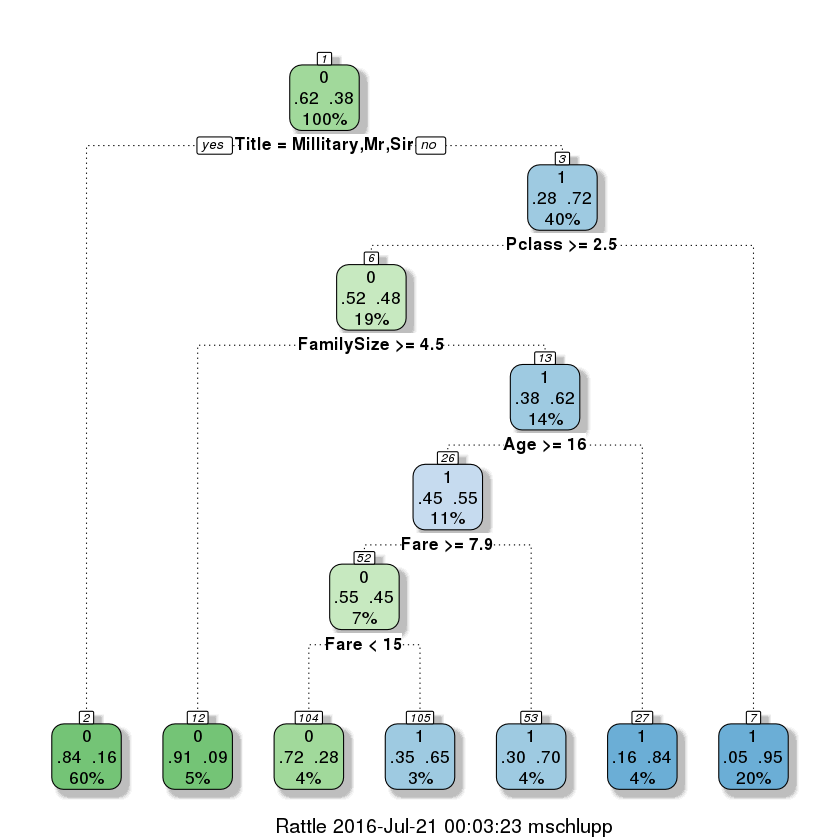

In [23]:
fancyRpartPlot(decTree)

### Predict a solution with this new tree

In [24]:
prediction <- predict(decTree, test, type='class')

In [25]:
test$Survived <- prediction

In [26]:
solution <- data.frame(PassengerId=test$PassengerId, Survived=test$Survived)

In [27]:
write.csv(solution, "solution.csv", row.names=FALSE)

This scores better than the other solutions so far. Now to ensemble methods.

# Predict survival with a random forest

First of all, random forrests cannot deal with empty variables, so we have to fill all missing variables in our dataset by hand. For example, a  lot of the age entries are missing.

In [28]:
summary(comb_data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

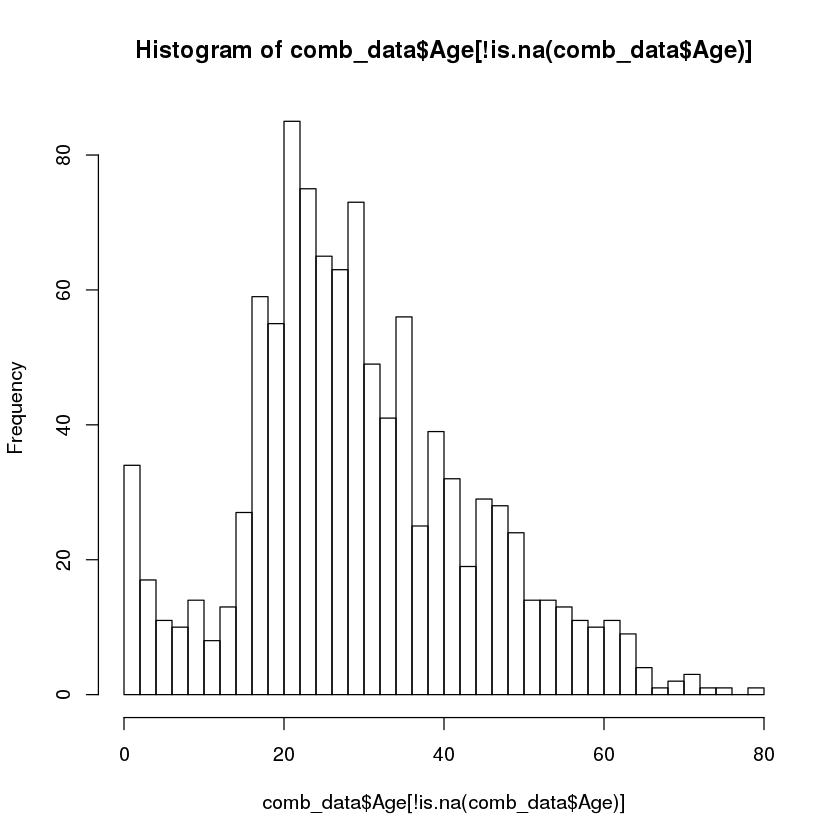

In [29]:
hist(comb_data$Age[!is.na(comb_data$Age)],40)

In [30]:
summary(comb_data$Age)
length(comb_data$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

[1] 1309

These are 263 NA's out of 1309 -- **20%**! 
If we want to use the age, we have to fill the NA values with numbers. Easy solution: take the mean oder median. However we can simply predict the age by using a decision tree.

In [31]:
# Before doing so, let's first keep track of the passenger id that haven't got an age yet
age_filled <- data.frame(pid=comb_data$PassengerId[is.na(comb_data$Age)])

In [32]:
head(comb_data,1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S,Mr,2


In [33]:
pred_age <- rpart(Age ~ Sex + Pclass + SibSp + Parch + Fare + Embarked + Title + FamilySize,
                 data=comb_data[!is.na(comb_data$Age),], # be aware of the , to select columns
                 method='anova',
                 control=rpart.control(cp=0.005, minsplit=20))

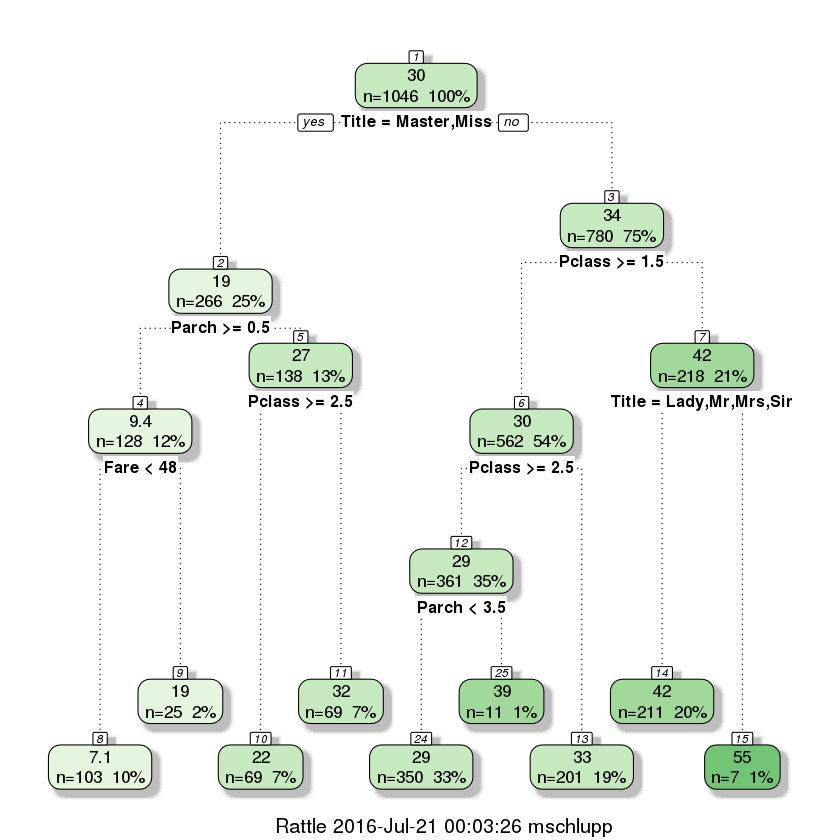

In [34]:
fancyRpartPlot(pred_age)

#### let's try  to prune the tree and find optimal depth (splits)

In [35]:
#print the complexity parameter (cp)
printcp(pred_age)
# a detailed summary can be printed with 'summary(pred_age)'


Regression tree:
rpart(formula = Age ~ Sex + Pclass + SibSp + Parch + Fare + Embarked + 
    Title + FamilySize, data = comb_data[!is.na(comb_data$Age), 
    ], method = "anova", control = rpart.control(cp = 0.005, 
    minsplit = 20))

Variables actually used in tree construction:
[1] Fare   Parch  Pclass Title 

Root node error: 217097/1046 = 207.55

n= 1046 

         CP nsplit rel error  xerror     xstd
1 0.2102841      0   1.00000 1.00121 0.045277
2 0.1051285      1   0.78972 0.79265 0.035242
3 0.0953713      2   0.68459 0.72807 0.034272
4 0.0143639      3   0.58922 0.59387 0.030395
5 0.0126697      4   0.57485 0.59398 0.030490
6 0.0105621      5   0.56218 0.58336 0.030396
7 0.0057626      6   0.55162 0.57168 0.030254
8 0.0050318      7   0.54586 0.57841 0.030852
9 0.0050000      8   0.54083 0.58395 0.031187


Let's use the tree with the smallest 'cross-validated error'

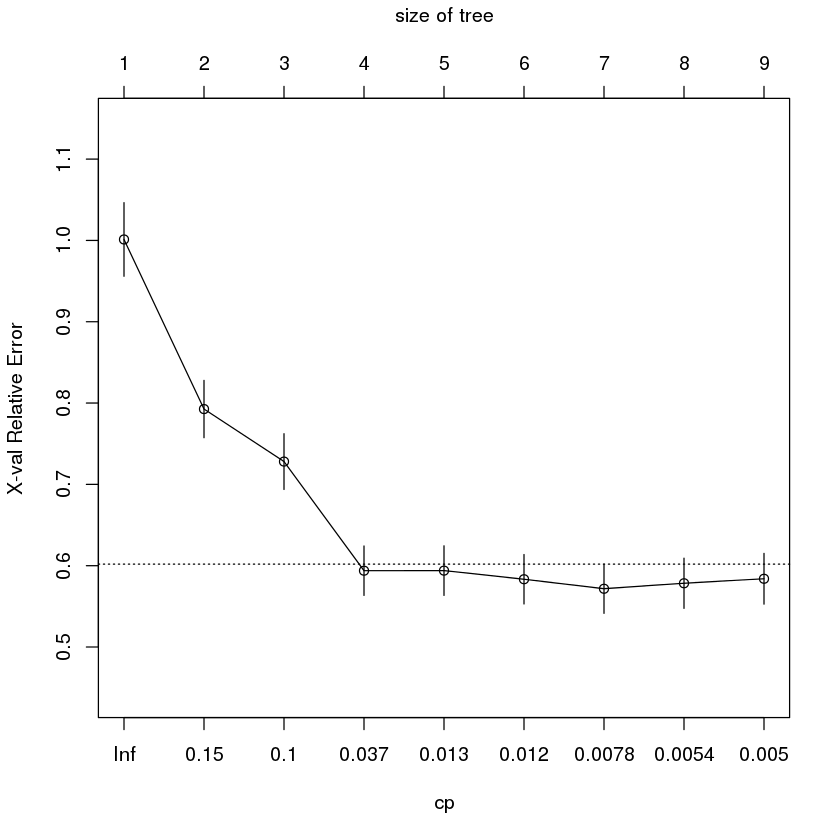

In [36]:
plotcp(pred_age) # 

In [37]:
# get min cp and prune the tree
min_cp=pred_age$cptable[which.min(pred_age$cptable[,'xerror']),'CP'] 
pred_age <- prune(pred_age, cp=min_cp)

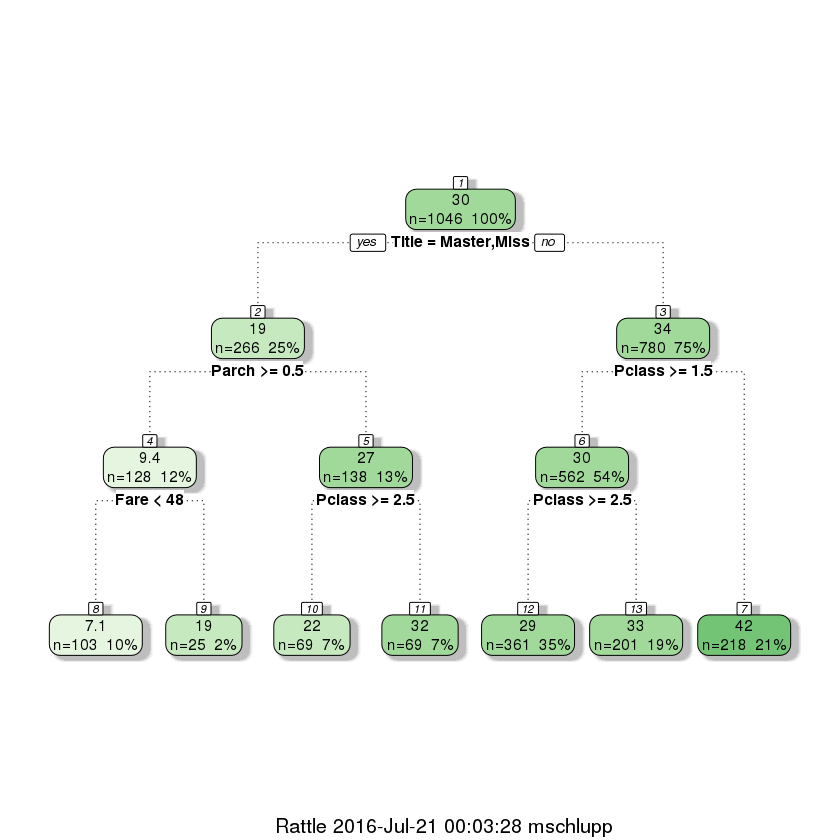

In [38]:
fancyRpartPlot(pred_age)

#### Now predict age and fill the dataset

In [39]:
new_age <- predict(pred_age, comb_data[is.na(comb_data$Age),])

let's try to compare the new ages to the orginially filled values

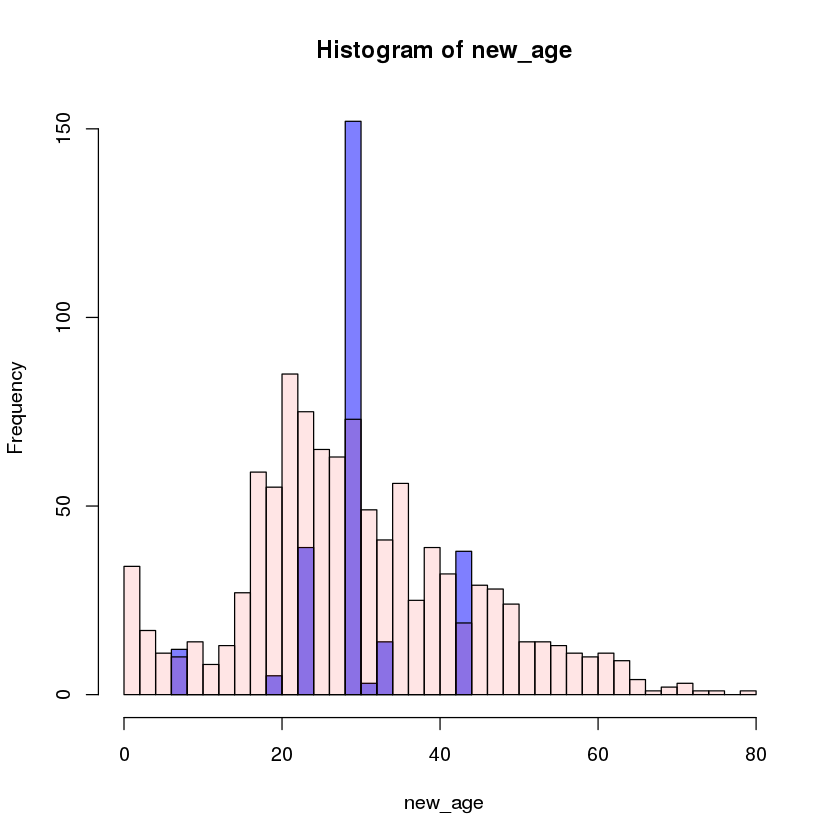

In [40]:
hist(new_age,20, xlim=c(0,81),col=rgb(0,0,1,0.5))
hist(comb_data$Age[!is.na(comb_data$Age)],40, xlim=c(0,81), col=rgb(1,0,0,0.1), add=T)


The possible predictions are categorized in seven values. This is way distributions cannot be the same at all. At least it is not totally off. Still you should evaluate an uncertainty on this method.

In [41]:
summary(new_age)
summary(comb_data$Age[!is.na(comb_data$Age)])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  7.124  28.860  28.860  28.930  28.860  42.420 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.17   21.00   28.00   29.88   39.00   80.00 

Assign new age values to our dataset

In [42]:
comb_data$Age[is.na(comb_data$Age)] <- new_age

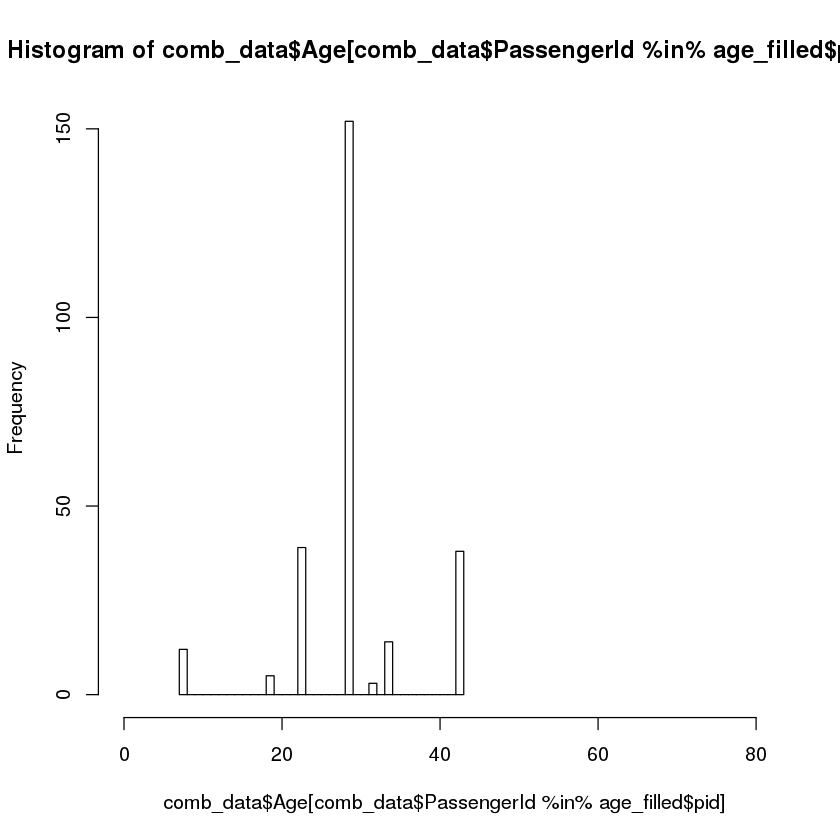

In [43]:
# make sure it has worked.
hist(comb_data$Age[ comb_data$PassengerId %in% age_filled$pid ],40, xlim=c(0,81))

#### Do we have other issue?

In [44]:
summary(comb_data)

  PassengerId      Survived          Pclass          Name          
 Min.   :   1   Min.   :0.0000   Min.   :1.000   Length:1309       
 1st Qu.: 328   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median : 655   Median :0.0000   Median :3.000   Mode  :character  
 Mean   : 655   Mean   :0.3838   Mean   :2.295                     
 3rd Qu.: 982   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :1309   Max.   :1.0000   Max.   :3.000                     
                NA's   :418                                        
     Sex           Age            SibSp            Parch            Ticket    
 female:466   Min.   : 0.17   Min.   :0.0000   Min.   :0.000   CA. 2343:  11  
 male  :843   1st Qu.:22.00   1st Qu.:0.0000   1st Qu.:0.000   1601    :   8  
              Median :28.86   Median :0.0000   Median :0.000   CA 2144 :   8  
              Mean   :29.69   Mean   :0.4989   Mean   :0.385   3101295 :   7  
              3rd Qu.:36.50   3rd Qu.:1.0000   3rd Qu.:0.000 


There missing values for _Fare_ (1) and _Embarked_ (2). For now, we haven't really used _Ticket_ or _Cabin_ (which---at least _Cabin_---probably are pretty much useless, anyhow). Let's find out, who the persons are where the _Embarked_ information is missing. We use `which` to find out.

In [45]:
# returns the indices of the boolean true rows
which(comb_data$Embarked=='')

[1]  62 830

As the majority entered the Titanic in Southampton, we assign 'S' to the missing passengers

In [46]:
comb_data$Embarked[c(62,830)] = 'S' # not sure why '=' and '<-' work
comb_data$Embarked[830]
comb_data$Embarked <- factor(comb_data$Embarked)

[1] S
Levels:  C Q S

Now we can take care of _Fare_

In [47]:
summary(comb_data$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.896  14.450  33.300  31.280 512.300       1 

In [48]:
# Let's see who the missing passenger is
comb_data[which(is.na(comb_data$Fare)),]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1044,1044,NA,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,1


The passenger travels in the third class, so we take the median of the third class fares

In [49]:
comb_data$Fare[1044] <- median(comb_data$Fare[comb_data$Pclass==3], na.rm=TRUE)

In [50]:
# split the combined set in test an training
train <- comb_data[1:length(train$PassengerId),]

In [51]:
# in the combined dataset the PassengerId==Index, that's why this line works. 
test <- comb_data[(which.max(train$PassengerId)+1):which.max(comb_data$PassengerId),]

## Train a random forest

In [52]:
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [53]:
# set random see, to get reproducible results (bootstrapping/baggin)
set.seed(666)

In [54]:
pred_rf <- randomForest(as.factor(Survived)~ Sex+Pclass+Age+Fare+FamilySize+Embarked+Title+Parch+SibSp,
                       data=train,
                       importance=TRUE, 
                       ntree=4000)

We ensure a classification by changing temporarily the _Survived_ feature to a factor. The `importance` control allows us to access the importance of each feature lator on.

In [55]:
print(pred_rf)


Call:
 randomForest(formula = as.factor(Survived) ~ Sex + Pclass + Age +      Fare + FamilySize + Embarked + Title + Parch + SibSp, data = train,      importance = TRUE, ntree = 4000) 
               Type of random forest: classification
                     Number of trees: 4000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 16.95%
Confusion matrix:
    0   1 class.error
0 492  57   0.1038251
1  94 248   0.2748538


Table of OOB (out of bag error -- mis-classification of elements not in the bootstrapped/bagged sample)
 
| OOB err [%] | ntree  | mtry  |
|---|---|---|
| 16.95  | 3k | 4 |
| 18.41  | 3k | 6 |
| 18.29  | 8k | 6 |
| 16.95  | 3k | 3 |
| 17.06  | 5k | 3 |
| 17.28  | 8k | 2 |
| 17.06  | 5k | 5 |
| 16.72  | 3k | 3 |

Keep in mind: randomly choosing variables per split allow to get different results for same RF hyperparameter.

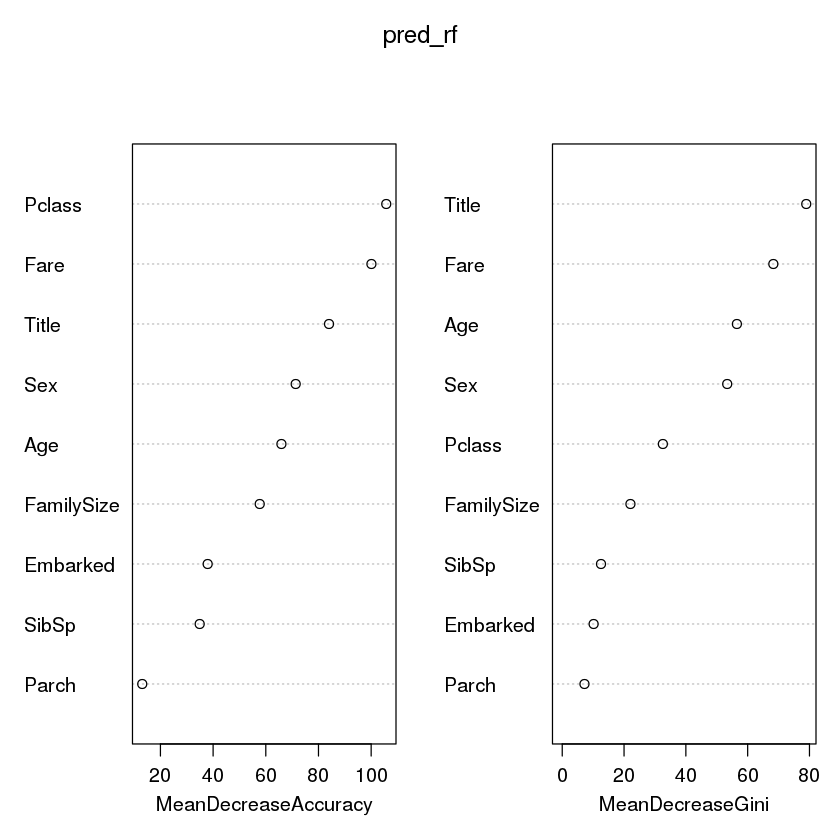

In [56]:
varImpPlot(pred_rf)

In [57]:
prediction <- predict(pred_rf, test)
pred_oob <- predict(pred_rf)

In [58]:
length(pred_oob)
length(prediction)

[1] 891

[1] 418

## write into csv and submit to kaggle

In [59]:
test$Survived <- prediction

In [60]:
solution <- data.frame(PassengerId=test$PassengerId, Survived=test$Survived)

In [61]:
write.csv(solution, "solution_rf.csv", row.names=FALSE)

The random forrest actually performs worse than the simple decision tree solution. 
Next try is a forest of conditional inference trees. 
Here, splits are performed by means of (multivariate) significance tests. This is supposed to be less biasing and one does not have to worry about growing the correct tree (depth etc...)


In [62]:
library(party)

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich


In [1]:
set.seed(666)

In [63]:
pred_ctree <- cforest(as.factor(Survived)~Pclass+Sex+Age+Fare+Title+SibSp+Parch+FamilySize+Embarked,
                     data=train,
                     control=cforest_unbiased(ntree=3000, mtry=3))
 #, testtype='MonteCarlo',nresample=15000, mincriterion=0.1))

In [64]:
test$Survived <- predict(pred_ctree, test, OOB=TRUE, type='response')

In [66]:
solution_ctree <- data.frame(PassengerId=test$PassengerId, Survived=test$Survived)

In [67]:
write.csv(solution_ctree, 'solution_ctree.csv', row.names=FALSE)